In [8]:
#pip install xarray rioxarray xarray-spatial geopandas tqdm scipy scikit-learn scikit-image
#! pip install seaborn 
#! pip install optuna-dashboard
#! pip install plotly

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt
import os
from pathlib import Path
import json

from xrspatial.multispectral import ndvi, evi, savi
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay, 
    PrecisionRecallDisplay, 
    precision_score,
    recall_score, 
    classification_report,
    accuracy_score, 
    f1_score
    )

import seaborn as sns
import optuna

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

The filepaths are stored in `src/model_config.json`. They keys are paths to the labeled polygons and the values are paths to the corresponding NAIP images.

In [ ]:
# open dict of {labeled_polygon: NAIP} pairs from config file
with open(Path(os.getcwd()) / 'model_config.json') as src:
    config = json.load(src)
len(config)

{'/home/michael/TreeMortality/data/huc180102110101and2/10TEL0509245547_2022_labels.gpkg': '/home/michael/TreeMortality/NAIP_train/m_4112249_se_10_060_20220718.tif',
 '/home/michael/TreeMortality/data/huc180102111107/10TDL0458245240_2022_labels.gpkg': '/home/michael/TreeMortality/data/huc180102111107/NAIP/2022/2022.vrt',
 '/home/michael/TreeMortality/data/huc180201520201/10TEK0503244655_2022_labels.gpkg': '/home/michael/TreeMortality/data/huc180201520201/NAIP/2022/2022.vrt',
 '/home/michael/TreeMortality/data/huc180102111105/10TDL0464245187_2022_labels.gpkg': '/home/michael/TreeMortality/data/huc180102111105/NAIP/2022/2022.vrt',
 '/home/michael/TreeMortality/data/huc180102111102/10TDL0480045075_2020_labels.gpkg': '/home/michael/TreeMortality/data/huc180102111102/NAIP/2020/2020.vrt',
 '/home/michael/TreeMortality/data/huc180102111102/10TDL0480045075_2022_labels.gpkg': '/home/michael/TreeMortality/data/huc180102111102/NAIP/2022/2022.vrt',
 '/home/michael/TreeMortality/data/huc180102111102

Here is what the labeled polygon file looks like.  The labels are in the column `2022`, this is the year of imagery used o create the labels.

In [29]:
gpd.read_file(list(config.keys())[0]).head()

,IDdalponte,label,geometry
0,8482.0,-1.0,"POLYGON ((509656.440 4554868.910, 509656.730 4..."
1,5354.0,-1.0,"POLYGON ((509935.430 4555100.410, 509935.280 4..."
2,1012.0,-1.0,"POLYGON ((509338.940 4555426.170, 509338.950 4..."
3,7508.0,-1.0,"POLYGON ((509462.910 4554933.610, 509462.810 4..."
4,6135.0,-1.0,"POLYGON ((509520.070 4555028.520, 509519.570 4..."


## Feature Engineering  
The next cell contains the function which engineers features for the model based on the pixel values found within each crown.  For each crown the function reads the image pixels within the crown, masks those that are in shadow or represent soil, and generates a number of summary features.  The red, green, blue and NIR bands are normalized at the image level before crown pixels are isolated in order to minimize image-to-image difference in luminosity. The masking of soil and shadows is based on luminosity. Values for the mask were developed by trial masking and inspection of images. Shadows are masked as any pixels with luminosity below 0.176and bare soil as pixels with luminosity above 0.569.

The feature engineering function produces the following features:

+ `lum10, lum20, ... , lum100` - fraction of pixels having luminosity between 0 and 0.1, 0.1 and 0.2, ...,  0.9 and 1.
+ `rgi10, rgi20, ... , rgi100` - fraction of pixels having relative greenness between 0 and 0.1, 0.1 and 0.2, ...,  0.9 and 1.
+ `r10, r20, ... , r100` - fraction of pixels having red, normalized at pixel level, between 0 and 0.1, 0.1 and 0.2, ...,  0.9 and 1.
+ `g10, g20, ... , g100` - fraction of pixels having green, normalized at pixel level, between 0 and 0.1, 0.1 and 0.2, ...,  0.9 and 1.
+ `b10, b20, ... , b100` - fraction of pixels having blue, normalized at pixel level, between 0 and 0.1, 0.1 and 0.2, ...,  0.9 and 1.
+ `n10, n20, ... , n100` - fraction of pixels having NIR, normalized at pixel level, between 0 and 0.1, 0.1 and 0.2, ...,  0.9 and 1.
+ `ndvi_mean, ndvi_std` - mean and standard deviation of NDVI of all masked pixels in within the crown.
+ `rgi_mean, rgi_std ` - mean and standard deviation of relative greenness of all masked pixels in within the crown.
+ `savi_mean, savi_std` - mean and standard deviation of SAVI of all pixels in within the crown (SAVI used unmasked data).
+ `r_mean, r_std` - mean and standard deviation of red, normalized at pixel level, of all masked pixels in within the crown.
+ `g_mean, g_std` - mean and standard deviation of green, normalized at pixel level, of all masked pixels in within the crown.
+ `b_mean, b_std` - mean and standard deviation of blue, normalized at pixel level, of all masked pixels in within the crown.
+ `n_mean, n_std` - mean and standard deviation of NIR, normalized at pixel level, of all masked pixels in within the crown.

In [30]:
def make_model_inputs(crowns, tif_path, label=None, IDcolumn=None):
    '''
    Returns DataFrame with features for use in classification model.
    The resulting DataFrame has 'ID' column which matches that in crowns.
    The DataFrame also has a 'label' column, see params for more detail.  

    params:
        crowns   - str - path to OGR readable vector file containing tree crowns.
        tif_path - str - path to image tif used in producing features.
        label    - str - specifies column containing labels.  If specified 'label'
                         column in resulting DataFrame will contain contents of 
                         specified column. Otherwise 'label' column contain -99.
        IDcolumn - str - column to use as matching ID with crowns
    '''

    # get the extent of the crowns
    xmin, ymin, xmax, ymax = crowns.total_bounds

    # open the naip image
    xa = rioxarray.open_rasterio(tif_path).astype(float).rio.clip_box(
        minx=xmin,
        miny=ymin,
        maxx=xmax,
        maxy=ymax
        ).to_dataset(name='band_data')

    # normalized the band_data
    band_data = xa.band_data.to_numpy().astype(float)
    band_data = (band_data - np.nanmin(band_data)) * (255 / (np.nanmax(band_data) - np.nanmin(band_data)))

    # calculate relative greenness
    red = band_data[0]
    green = band_data[1]
    blue = band_data[2]
    nir = band_data[3]
    rgi = green / (red + green + blue)
    xa['rgi'] = (('y', 'x'), rgi)

    # calculate pixel by pixel normalized R, G, B, and NIR
    rgbn_tot = red + green + blue + nir
    xa['red_'] = (('y', 'x'), red  / rgbn_tot)
    xa['blue_'] = (('y', 'x'), blue  / rgbn_tot)
    xa['green_'] = (('y', 'x'), green  / rgbn_tot)
    xa['nir_'] = (('y', 'x'), nir  / rgbn_tot)

    # calculate NDVI and SAVI
    nir_agg = xa.band_data[3].astype(float)
    red_agg = xa.band_data[2].astype(float)
    ndvi_agg = ndvi(nir_agg, red_agg)
    savi_agg = savi(nir_agg, red_agg)
    xa['NDVI'] = ndvi_agg
    xa['SAVI'] = savi_agg

    # calculate RGB luminosity
    luminosity = band_data[:3].mean(axis=0) / 255
    xa['luminosity'] = (('y', 'x'), luminosity)

    # mask out shadows and soil for RGI,NDVI, and normed pix colors
    mask = (luminosity > 0.176) & (luminosity < 0.569)
    masked_rgi = xa.rgi.where(mask)
    masked_ndvi = xa.NDVI.where(mask)
    r_ = xa.red_.where(mask)
    g_ = xa.green_.where(mask)
    b_ = xa.blue_.where(mask)
    n_ = xa.nir_.where(mask)
    
    print('adding index data...')
    data = []
    masked_count = 0
    total = len(crowns)
    bins = np.arange(0.1, 1.1, 0.1)
    with tqdm(total=total) as progress_bar:
        for _, row in crowns.iterrows():
            # calculate luminosity fractions
            lum = xa.luminosity.rio.clip([row.geometry]).to_numpy().flatten()
            lum_tot = lum.shape[0]
            lum_fracs = [((lum < f).sum() - (lum < f - 0.1).sum()) / lum_tot for f in bins]

            # calculate rgi fracs
            rgi = masked_rgi.rio.clip([row.geometry]).to_numpy().flatten()
            rgi = rgi[~np.isnan(rgi)]
            rgi_tot = len(rgi)
            if rgi_tot == 0:
                rgi_fracs = [-99] * 10
            else:
                rgi_fracs = [((rgi < f).sum() - (rgi < f - 0.1).sum()) / rgi_tot for f in bins]
                
            # and normed pix colr fracs
            r = r_.rio.clip([row.geometry]).to_numpy().flatten()
            r = r[~np.isnan(r)]
            c_tot = len(r)
            
            g = g_.rio.clip([row.geometry]).to_numpy().flatten()
            g = g[~np.isnan(g)]

            b = b_.rio.clip([row.geometry]).to_numpy().flatten()
            b = b[~np.isnan(b)]

            n = n_.rio.clip([row.geometry]).to_numpy().flatten()
            n = n[~np.isnan(n)]

            if c_tot == 0:
                r_fracs = [-99] * 10
                g_fracs = [-99] * 10
                b_fracs = [-99] * 10
                n_fracs = [-99] * 10
            else:
                r_fracs = [((r < f).sum() - (r < f - 0.1).sum()) / c_tot for f in bins]
                g_fracs = [((g < f).sum() - (g < f - 0.1).sum()) / c_tot for f in bins]
                b_fracs = [((b < f).sum() - (b < f - 0.1).sum()) / c_tot for f in bins]
                n_fracs = [((n < f).sum() - (n < f - 0.1).sum()) / c_tot for f in bins]
                        
            # calculate means and stdevs
            if rgi_tot == 0:
                ndvi_mean, ndvi_std = -99, -99
                rgi_mean, rgi_std = -99, -99
                savi_mean, savi_std = -99, -99
                r_mean, r_std = -99, -99
                g_mean, g_std = -99, -99
                b_mean, b_std = -99, -99
                n_mean, n_std = -99, -99
            else:
                #NOTE: .values * 1 casts 1 item DataArray to float
                ndvi_mean, ndvi_std = masked_ndvi.mean().values * 1, masked_ndvi.std().values * 1
                rgi_mean, rgi_std = rgi.mean(), rgi.std()
                savi_mean, savi_std = xa.SAVI.mean().values * 1, xa.SAVI.std().values * 1
                r_mean, r_std = r.mean(), r.std()
                g_mean, g_std = g.mean(), g.std()
                b_mean, b_std = b.mean(), b.std()
                n_mean, n_std = n.mean(), n.std()

            if label is None:
                row[label] = -99

            data.append(
                [row[IDcolumn], (row[label] + 1) / 2] +
                lum_fracs +
                rgi_fracs + 
                r_fracs + 
                g_fracs + 
                b_fracs + 
                n_fracs +
                [ndvi_mean, ndvi_std, rgi_mean, rgi_std, savi_mean, savi_std] +
                [r_mean, r_std, g_mean, g_std, b_mean, b_std, n_mean, n_std]
                )

            #count polygon if has masked pixels            
            if rgi_tot < len(xa.rgi.rio.clip([row.geometry]).to_numpy().flatten()):
                masked_count = masked_count + 1

            progress_bar.update(1)

    cols = [IDcolumn, 'label',
            'lum10', 'lum20', 'lum30', 'lum40', 'lum50', 'lum60' ,'lum70', 'lum80', 'lum90', 'lum100',
            'rgi10', 'rgi20', 'rgi30', 'rgi40', 'rgi50', 'rgi60' ,'rgi70', 'rgi80', 'rgi90', 'rgi100',
            'r10', 'r20', 'r30', 'r40', 'r50', 'r60' ,'r70', 'r80', 'r90', 'r100',
            'g10', 'g20', 'g30', 'g40', 'g50', 'g60' ,'g70', 'g80', 'g90', 'g100',
            'b10', 'b20', 'b30', 'b40', 'b50', 'b60' ,'b70', 'b80', 'b90', 'b100',
            'n10', 'n20', 'n30', 'n40', 'n50', 'n60' ,'n70', 'n80', 'n90', 'n100',
            'ndvi_mean', 'ndvi_std', 'rgi_mean', 'rgi_std', 'savi_mean', 'savi_std',
            'r_mean', 'r_std', 'g_mean', 'g_std', 'b_mean', 'b_std', 'n_mean', 'n_std']

    data = pd.DataFrame(data, columns=cols) 

    print(f'{masked_count}/{total} ({100 * masked_count / total:.1f}%)of crowns contained masked pixels')

    return data



First we enter paths to the labeled crowns (in two separate files `crown_path` and `crown_path2`) and the 2022 NAIP image (`tif_path`) we will use for training.  Then we open the crowns as a GeoDataFrame.  We will only keep the labeled crowns (the number of labeled crowns is constantly growing as more crowns are hand labeled). We will also throw out crowns with a canpoy smalller than 10 $\mathrm{m}^{2}$.

In [31]:
# TODO: make join ttops with crowns, then use ttop location for this
# function rather than centroid.

def make_unique_ID(crowns, utm_zone):
    '''
    returns copy of dataframe with new uniqueID column
    with entries of form 'utm_zone_x_y where x and y 
    are rounded to the nearest meter.
    '''
    crowns['UniqueID'] = crowns.geometry.centroid.apply(
        lambda p: f'{utm_zone}_{p.x:.0f}_{p.y:.0f}')
    
    return crowns

In [32]:
label_col = 'label'
data = []
for gpkg, tif in config.items():
    # open crowns and keep only those that are classified 
    crowns = gpd.read_file(gpkg).dropna(subset=[label_col]).set_index('IDdalponte', drop=False)
    crowns = crowns[crowns.geometry.area > 10]
    # make uniqueID
    crowns = make_unique_ID(crowns, 10)
    # append engineered features df to list
    data.append(make_model_inputs(crowns, tif, label=label_col, IDcolumn='UniqueID'))


adding index data...


100%|██████████| 832/832 [04:00<00:00,  3.45it/s]


832/832 (100.0%)of crowns contained masked pixels
adding index data...


100%|██████████| 916/916 [04:13<00:00,  3.61it/s]


911/916 (99.5%)of crowns contained masked pixels
adding index data...


100%|██████████| 1112/1112 [05:07<00:00,  3.62it/s]


1112/1112 (100.0%)of crowns contained masked pixels
adding index data...


100%|██████████| 1763/1763 [08:09<00:00,  3.60it/s]


1762/1763 (99.9%)of crowns contained masked pixels


Warning 1: /home/michael/TreeMortality/data/huc180102111102/NAIP/2020/m_4012316_sw_10_060_20200710.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /home/michael/TreeMortality/data/huc180102111102/NAIP/2020/m_4012324_nw_10_060_20200710.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /home/michael/TreeMortality/data/huc180102111102/NAIP/2020/m_4012324_sw_10_060_20200710.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


adding index data...


100%|██████████| 1274/1274 [06:10<00:00,  3.44it/s]


1274/1274 (100.0%)of crowns contained masked pixels
adding index data...


100%|██████████| 2331/2331 [11:01<00:00,  3.52it/s]


2331/2331 (100.0%)of crowns contained masked pixels
adding index data...


100%|██████████| 164/164 [00:47<00:00,  3.49it/s]

164/164 (100.0%)of crowns contained masked pixels


In [15]:
data = pd.concat(data)

In [16]:
data['y'] = data.label.round().astype(int)
train, test = train_test_split(data, test_size=0.5)

In [17]:
from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

## Model Tuning and Feature Selection
Next we will tune the model parameters using all of the engineered features.  This will give us insight into which features are most useful for classifying the crowns.  Then we can select the features we want to use along with the model parameters.

In [18]:

def objective(trial):
    cols = train.drop(['y', 'label', 'UniqueID'], axis=1).columns
    X = train[cols]
    y = train.y

    class_weight = {
        0: (len(y) - y.sum()) / len(y),
        1: y.sum() / len(y)
    }

    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    
    if classifier_name == 'SVC':
        svc_c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        svc_kernel = trial.suggest_categorical('svc_kernel', ['rbf', 'sigmoid'])
        
        classifier_obj = SVC(
            C=svc_c,
            kernel=svc_kernel,
            gamma='auto',
            class_weight=class_weight
            )
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        rf_max_features = trial.suggest_float("rf_max_features", 1e-10, 1, log=True)
        rf_max_samples = trial.suggest_float("rf_max_samples", 3e-10, 1)
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 2, 64, log=True)
        
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth,
            max_features=rf_max_features,
            n_estimators=rf_n_estimators,
            #max_samples=rf_max_samples,
            random_state=np.random.seed(1234)
        )
        
    score = cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=3, scoring='roc_auc')
    roc = score.mean()
    return roc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print('--------------------\n', study.best_trial, '--------------------\n')
print(f'ROC AUC: {study.best_trial.values[0]}')
_ = [print(key, val) for key, val in study.best_trial.params.items()]

[I 2023-06-29 18:25:33,783] A new study created in memory with name: no-name-a4cb7945-67ec-4a14-b3c3-c99f46d38ed3
[I 2023-06-29 18:25:37,487] Trial 0 finished with value: 0.9895552696265965 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 19, 'rf_max_features': 1.068612165408501e-10, 'rf_max_samples': 0.17210219971840568, 'rf_n_estimators': 6}. Best is trial 0 with value: 0.9895552696265965.
[I 2023-06-29 18:25:38,255] Trial 1 finished with value: 0.9803667717985247 and parameters: {'classifier': 'SVC', 'svc_c': 0.7336996788169717, 'svc_kernel': 'sigmoid'}. Best is trial 0 with value: 0.9895552696265965.
[I 2023-06-29 18:25:38,874] Trial 2 finished with value: 0.9773477575449158 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 21, 'rf_max_features': 0.5372442692575684, 'rf_max_samples': 0.7080488453149356, 'rf_n_estimators': 2}. Best is trial 0 with value: 0.9895552696265965.
[I 2023-06-29 18:25:39,417] Trial 3 finished with value: 0.986539418959469 and para

[I 2023-06-29 18:25:43,544] Trial 7 finished with value: 0.9926460227530739 and parameters: {'classifier': 'SVC', 'svc_c': 2814322.975750681, 'svc_kernel': 'rbf'}. Best is trial 7 with value: 0.9926460227530739.
[I 2023-06-29 18:25:43,692] Trial 8 finished with value: 0.9823147886693434 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 22, 'rf_max_features': 1.5777008183730686e-07, 'rf_max_samples': 0.9845943058155776, 'rf_n_estimators': 3}. Best is trial 7 with value: 0.9926460227530739.
[I 2023-06-29 18:25:44,177] Trial 9 finished with value: 0.978811464845807 and parameters: {'classifier': 'SVC', 'svc_c': 5.671571302696077e-07, 'svc_kernel': 'rbf'}. Best is trial 7 with value: 0.9926460227530739.
[I 2023-06-29 18:26:05,866] Trial 10 finished with value: 0.9847816678436329 and parameters: {'classifier': 'SVC', 'svc_c': 2866512992.1313176, 'svc_kernel': 'rbf'}. Best is trial 7 with value: 0.9926460227530739.
[I 2023-06-29 18:26:06,137] Trial 11 finished with value: 0.9894

--------------------
 FrozenTrial(number=428, state=TrialState.COMPLETE, values=[0.9954085498451325], datetime_start=datetime.datetime(2023, 6, 29, 18, 28, 26, 367514), datetime_complete=datetime.datetime(2023, 6, 29, 18, 28, 26, 673617), params={'classifier': 'RandomForest', 'rf_max_depth': 17, 'rf_max_features': 1.3904890770260134e-06, 'rf_max_samples': 0.39760367064189145, 'rf_n_estimators': 38}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'rf_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'rf_max_features': FloatDistribution(high=1.0, log=True, low=1e-10, step=None), 'rf_max_samples': FloatDistribution(high=1.0, log=False, low=3e-10, step=None), 'rf_n_estimators': IntDistribution(high=64, log=True, low=2, step=1)}, trial_id=428, value=None) --------------------

ROC AUC: 0.9954085498451325
classifier RandomForest
rf_max_depth 17
rf_max_features 1.3904890770260134e-06
r

model with 38 estimators and max depth of 17.
ROC AUC: 1.0

Feature ranking:
   1.  rgi50 (0.087062)
   2.  n_mean (0.068090)
   3.  r_mean (0.065529)
   4.  g_mean (0.062959)
   5.  n50 (0.055575)
   6.  r30 (0.054618)
   7.  rgi40 (0.051831)
   8.  n30 (0.046583)
   9.  r20 (0.046300)
   10.  g40 (0.035470)
   11.  rgi_mean (0.035285)
   12.  b30 (0.027659)
   13.  lum70 (0.022371)
   14.  r10 (0.019469)
   15.  b_mean (0.018290)
   16.  lum30 (0.016848)
   17.  lum60 (0.016574)
   18.  g_std (0.016397)
   19.  savi_mean (0.016052)
   20.  b20 (0.015723)
   21.  lum40 (0.014343)
   22.  ndvi_mean (0.013746)
   23.  savi_std (0.012733)
   24.  b_std (0.012352)
   25.  n60 (0.012342)
   26.  n40 (0.012013)
   27.  ndvi_std (0.011186)
   28.  r40 (0.011092)
   29.  n20 (0.011055)
   30.  lum20 (0.010986)
   31.  g30 (0.010617)
   32.  g20 (0.009629)
   33.  rgi_std (0.009555)
   34.  r_std (0.009536)
   35.  lum50 (0.009489)
   36.  n_std (0.009167)
   37.  lum80 (0.007387)
   38.  b40 

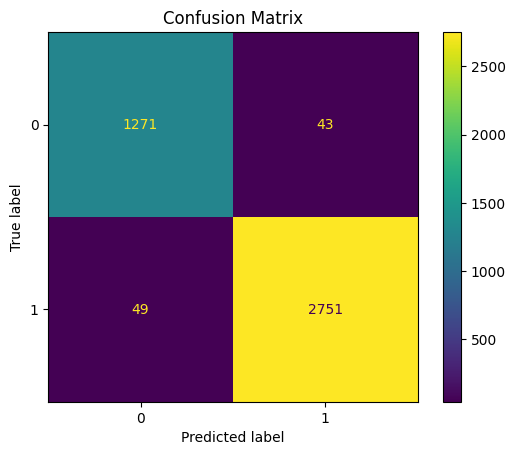

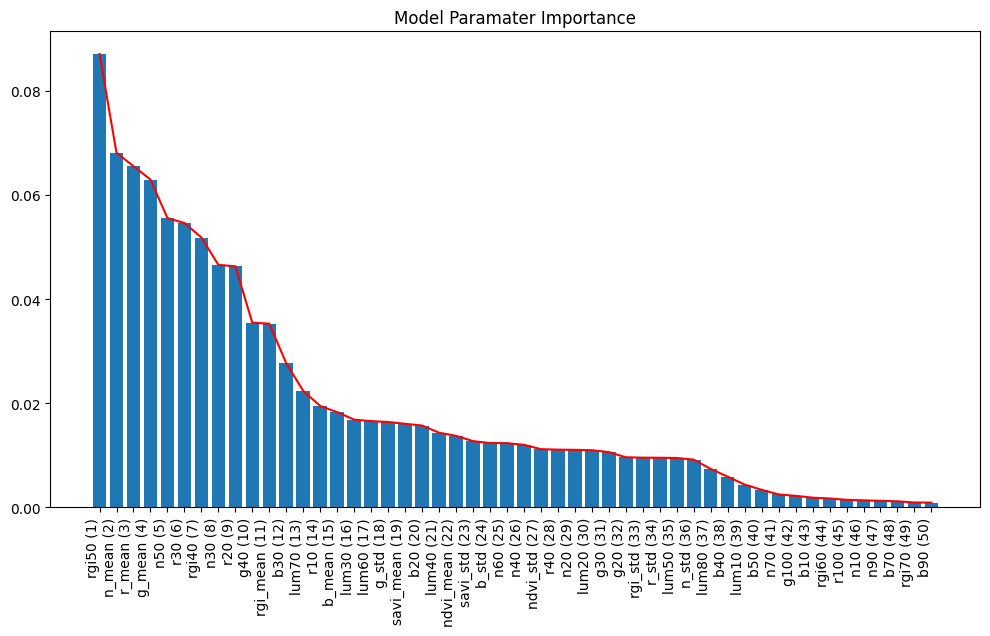

In [19]:
cols = train.drop(['y', 'UniqueID', 'label'], axis=1).columns

X = train[cols]
y = train.y

X_test = test[cols]
y_test = test.y

bst = study.best_trial.params
rf_max_depth = bst['rf_max_depth']
rf_max_features = bst['rf_max_features']
#rf_max_samples = bst['rf_max_samples']
rf_n_estimators = bst['rf_n_estimators']

model = RandomForestClassifier(
    max_depth=rf_max_depth,
    max_features=rf_max_features,
    n_estimators=rf_n_estimators,
    #max_samples=rf_max_samples,
    random_state=np.random.seed(1234)
).fit(X, y)


# use 10 fold validation
score = cross_val_score(model, X_test, y_test, n_jobs=-1, cv=10, scoring='roc_auc')

# report and plot first n features
n_feat = range(50)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print(f'model with {rf_n_estimators} estimators and max depth of {rf_max_depth}.')
print(f'ROC AUC: {score.mean().round(2)}')
print('\nFeature ranking:')
for f in n_feat:
    print('   %d.  %s (%f)' % (f + 1, cols[indices[f]], importances[indices[f]]))

pred = model.predict(X_test)

cm = confusion_matrix(y_test, pred)
cm_display1 = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')

fig, ax = plt.subplots(figsize=(12, 7))
fig.autofmt_xdate(rotation=45)
ax.bar(n_feat, importances[indices[n_feat]]);
ax.plot(n_feat, importances[indices[n_feat]], c='r');
ax.set_xticks(n_feat,rotation=90, labels=n_feat);
ax.set_xticklabels([f'{cols[indices[i]]} ({i+1})' for i in n_feat]);
ax.set_title('Model Paramater Importance');

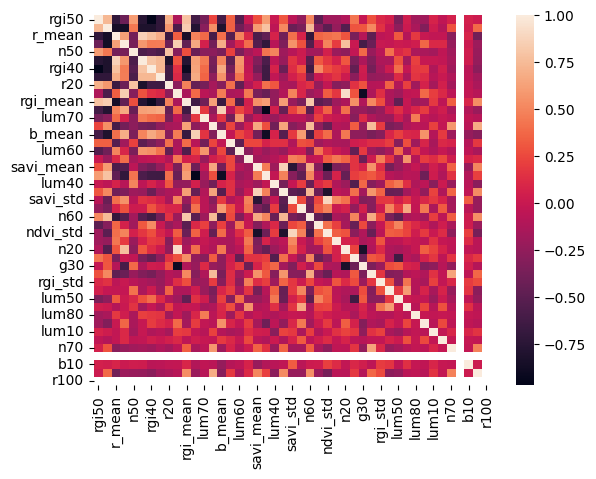

In [20]:
# number of variables to use
n_cols = 45

use_cols = cols[indices[:n_cols]]
sns.heatmap(data=data[data.n50 != -99][use_cols].corr());

imp = optuna.importance.get_param_importances(study)
params_sorted = list(imp.keys())

### Plot
fig = optuna.visualization.plot_rank(study, params=params_sorted[:4])
fig.show()

In [21]:
# get model params
use_cols = cols[indices[:n_cols]]
X = train[use_cols]
y = train.y

final_model = RandomForestClassifier(
    n_estimators=rf_n_estimators,
    max_features=rf_max_features,
    max_depth=rf_max_depth,
    #max_samples=rf_max_samples,
    oob_score=False,
    random_state=np.random.seed(1234)
).fit(X, y)


X_test = test[use_cols]
y_test = test.y

roc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1])
print(f'ROC AUC: {roc:.3f}')

ROC AUC: 0.997


In [22]:
pred_prob = final_model.predict_proba(X_test)
alive_prob = pred_prob[:,1]

In [23]:
# save the model to disk
import pickle
filename = '/home/michael/TreeMortality/src/RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

### Test sensitivity to quantity of training data

In order to test how the number of labeled polygons provided in training affects the model performance we then run a series of trials drawing different sized samples from the training dataset.

In [24]:
from joblib import Parallel, delayed

In [25]:

def sample_rep(df, frac, replicates):
    '''a sample generator function'''
    for i in range(replicates):
        yield df.sample(frac=frac)

def inner_func(train, frac, replicates):
    n_crowns = []
    roc = []
    for samp in sample_rep(train, frac, replicates):
        X = samp[use_cols]
        y = samp.y
        
        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            max_features=rf_max_features,
            max_depth=rf_max_depth,
            random_state=np.random.seed(1234)
        ).fit(X, y)
        
        n_crowns.append(len(samp))
        roc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
        
    df = pd.DataFrame()
    df['n_crowns'] = n_crowns
    df['ROC_AUC'] = roc
        
    return df


def n_train_sensitivity_test(train, test, use_cols, step=0.01, replicates=10):
    # get test data
    X_test = test[use_cols]
    y_test = test.y
    
    
    # run replicates at each fraction
    dfs = Parallel(n_jobs=10)(
        delayed(inner_func)
        (train, frac, replicates) 
        for frac in list(np.arange(0.1, 1, step)) +[1])
        
    score_df = pd.concat(dfs)

    return score_df

Text(0.5, 1.0, 'Model performance vs. number of training crowns\nBest ROC AUC:1.00')

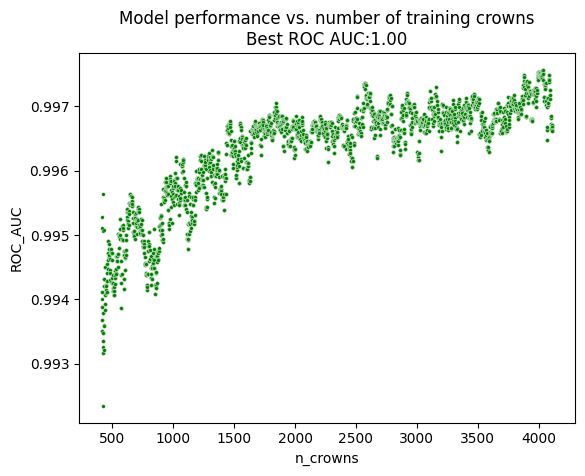

In [26]:
score_df = n_train_sensitivity_test(train, test, use_cols, step=0.0005, replicates=3)
sns.scatterplot(data=score_df, x='n_crowns', y='ROC_AUC', s=7, color='g');
plt.title(f'Model performance vs. number of training crowns\nBest ROC AUC:{score_df.ROC_AUC.max():.2f}')

## Predictions on full tile for 2018, 2020, and 2022

In [ ]:
tile = '/home/michael/data/TreeMortality/crowns/USGS_LPC_CA_CarrHirzDeltaFires_2019_B19_10TEL0509245547.gpkg'

crowns = gpd.read_file(tile).set_index('IDdalponte', drop=False)
crowns = crowns[crowns.geometry.area > 10]

tif2022_path = '/home/michael/data/TreeMortality/NAIP_m_4112249_se_10_1_20090623/m_4112249_se_10_060_20220718.tif'
tif2020_path = '/home/michael/data/TreeMortality/NAIP_m_4112249_se_10_1_20090623/m_4112249_se_10_060_20200709.tif'
tif2018_path = '/home/michael/data/TreeMortality/NAIP_m_4112249_se_10_1_20090623/m_4112249_se_10_060_20180926.tif'

data2022 = make_model_inputs(crowns, tif2022_path)
X2022 = data2022[cols]
y_pred_2022 = final_model.predict(X2022)
data2022['y_pred_2022'] = y_pred_2022
data2022 = data2022[['IDdalponte', 'y_pred_2022']]
data2022 = data2022.set_index('IDdalponte')

data2020 = make_model_inputs(crowns, tif2020_path)
X2020 = data2020[cols]
y_pred_2020 = final_model.predict(X2020)
data2020['y_pred_2020'] = y_pred_2020
data2020 = data2020[['IDdalponte', 'y_pred_2020']]
data2020 = data2020.set_index('IDdalponte')

data2018 = make_model_inputs(crowns, tif2018_path)
X2018 = data2018[cols]
y_pred_2018 = final_model.predict(X2018)
data2018['y_pred_2018'] = y_pred_2018
data2018 = data2018[['IDdalponte', 'y_pred_2018']]
data2018 = data2018.set_index('IDdalponte')


adding index data...


100%|██████████| 9754/9754 [33:36<00:00,  4.84it/s]


9754/9754 (100.0%)of crowns contained masked pixels


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


adding index data...


100%|██████████| 9754/9754 [33:55<00:00,  4.79it/s]


9754/9754 (100.0%)of crowns contained masked pixels
adding index data...


100%|██████████| 9754/9754 [34:59<00:00,  4.65it/s]


9754/9754 (100.0%)of crowns contained masked pixels


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [208]:

data = pd.merge(pd.merge(data2022, data2020, left_index=True, right_index=True), data2018, left_index=True, right_index=True)
data

,y_pred_2022,y_pred_2020,y_pred_2018
IDdalponte,,,
35,0,1,1
37,1,1,1
38,0,1,1
39,1,1,1
40,0,0,1
...,...,...,...
10062,0,1,1
10063,0,1,1
10064,0,1,1


In [209]:
# make sure that if a tree is alive, it was not dead in previous years.
lazurus = 0
for i, row in data.iterrows():
    if row.y_pred_2022 == 1:
        if (row.y_pred_2020 == 0) | (row.y_pred_2018 == 0):
            lazurus = lazurus + 1
            row['y_pred_2020'] = 1
            row['y_pred_2018'] = 1
print(f'there were {lazurus} resurections out of {len(data)} polygons.')
            


there were 100 resurections out of 9754 polygons.


In [212]:
crowns.index = crowns.index.astype(int)

crowns = crowns.join(
    data[['y_pred_2022', 'y_pred_2020', 'y_pred_2018']],
    how='left'
    )

In [213]:
crowns.columns

Index(['IDdalponte', 'zmax', 'zmean', 'zsd', 'zskew', 'zkurt', 'zentropy',
       'pzabovezmean', 'pzabove2', 'zq5', 'zq10', 'zq15', 'zq20', 'zq25',
       'zq30', 'zq35', 'zq40', 'zq45', 'zq50', 'zq55', 'zq60', 'zq65', 'zq70',
       'zq75', 'zq80', 'zq85', 'zq90', 'zq95', 'zpcum1', 'zpcum2', 'zpcum3',
       'zpcum4', 'zpcum5', 'zpcum6', 'zpcum7', 'zpcum8', 'zpcum9', 'itot',
       'imax', 'imean', 'isd', 'iskew', 'ikurt', 'ipground', 'ipcumzq10',
       'ipcumzq30', 'ipcumzq50', 'ipcumzq70', 'ipcumzq90', 'p1th', 'p2th',
       'p3th', 'p4th', 'p5th', 'pground', 'n', 'area', 'geometry',
       'y_pred_2022', 'y_pred_2020', 'y_pred_2018'],
      dtype='object')

In [216]:
# write the crowns
out_path = '/home/michael/data/TreeMortality/crowns/USGS_LPC_CA_CarrHirzDeltaFires_2019_B19_10TEL0509245547_pred.gpkg'
crowns.to_file(out_path, index=False)

In [226]:
for y in [2018, 2020, 2022]:
    pred = f'y_pred_{y}'
    print(
        f'{y}: {len(crowns) - crowns[pred].sum()} dead.'
    )
    print(
        f'{y}: {100 * (len(crowns) - crowns[pred].sum()) / len(crowns):.0f}% dead.\n'
    )
print(f'Out of total {len(crowns)} Crowns')

2018: 386 dead.
2018: 4% dead.

2020: 484 dead.
2020: 5% dead.

2022: 7100 dead.
2022: 73% dead.

Out of total 9754 Crowns


## Validation on other tile (10TDL0458245240) for  2022

adding index data...


100%|██████████| 916/916 [04:20<00:00,  3.52it/s]

911/916 (99.5%)of crowns contained masked pixels


model with 16 estimators and max depth of 13.
ROC AUC: 1.0

Feature ranking:
   1.  b_mean (0.083120)
   2.  g40 (0.068324)
   3.  r20 (0.067102)
   4.  r_mean (0.057728)
   5.  b10 (0.053508)
   6.  rgi_mean (0.042706)
   7.  lum20 (0.039890)
   8.  n60 (0.038582)
   9.  r40 (0.038568)
   10.  n20 (0.037550)
   11.  g_mean (0.034337)
   12.  g30 (0.033504)
   13.  b30 (0.033227)
   14.  n_mean (0.032607)
   15.  rgi40 (0.032295)
   16.  b_std (0.028264)
   17.  lum10 (0.027994)
   18.  b20 (0.026131)
   19.  g_std (0.018626)
   20.  rgi50 (0.017553)
   21.  n_std (0.017506)
   22.  lum60 (0.016957)
   23.  n50 (0.016726)
   24.  n30 (0.016609)
   25.  r_std (0.015651)
   26.  r30 (0.014113)
   27.  lum50 (0.012546)
   28.  lum40 (0.012527)
   29.  rgi_std (0.012150)
   30.  lum30 (0.009175)
   31.  lum70 (0.008529)
   32.  n40 (0.007556)
   33.  rgi60 (0.006288)
   34.  n10 (0.006085)
   35.  b50 (0.003506)
   36.  g20 (0.003156)
   37.  b90 (0.002341)
   38.  ndvi_std (0.002000)
   3

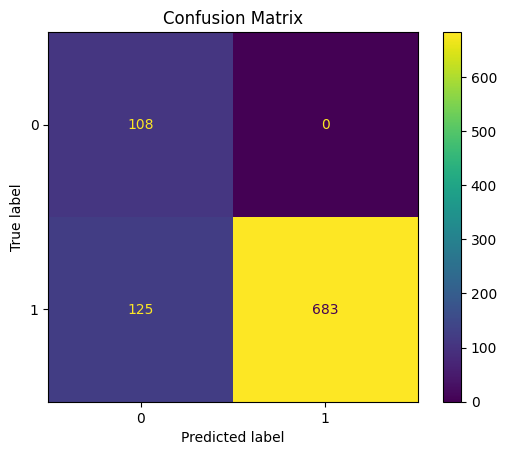

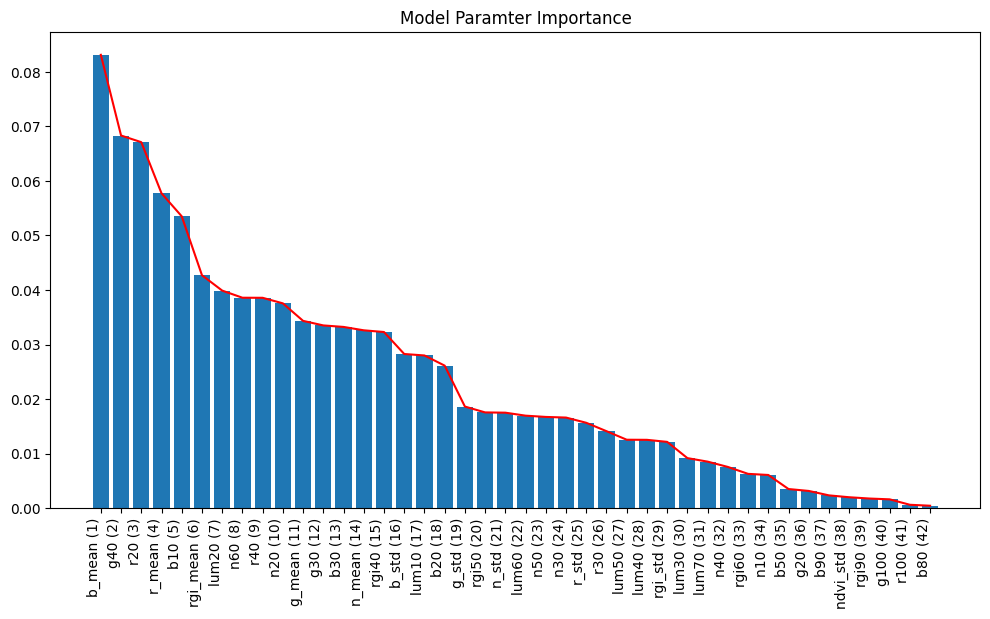

In [38]:

crown_path2 = '/home/michael/TreeMortality/data/train/10TDL0458245240_labels.gpkg'
crowns = gpd.read_file(crown_path2).dropna(subset=['2022']).set_index('IDdalponte', drop=False)
crowns = crowns[crowns.geometry.area > 10]

tif2022_path = '//home/michael/TreeMortality/data/huc180102111107/NAIP/2022/2022.vrt'

data2022 = make_model_inputs(crowns, tif2022_path, label='2022')



model with 16 estimators and max depth of 13.
ROC AUC: 1.0

Feature ranking:
   1.  b_mean (0.083120)
   2.  g40 (0.068324)
   3.  r20 (0.067102)
   4.  r_mean (0.057728)
   5.  b10 (0.053508)
   6.  rgi_mean (0.042706)
   7.  lum20 (0.039890)
   8.  n60 (0.038582)
   9.  r40 (0.038568)
   10.  n20 (0.037550)
   11.  g_mean (0.034337)
   12.  g30 (0.033504)
   13.  b30 (0.033227)
   14.  n_mean (0.032607)
   15.  rgi40 (0.032295)
   16.  b_std (0.028264)
   17.  lum10 (0.027994)
   18.  b20 (0.026131)
   19.  g_std (0.018626)
   20.  rgi50 (0.017553)
   21.  n_std (0.017506)
   22.  lum60 (0.016957)
   23.  n50 (0.016726)
   24.  n30 (0.016609)
   25.  r_std (0.015651)
   26.  r30 (0.014113)
   27.  lum50 (0.012546)
   28.  lum40 (0.012527)
   29.  rgi_std (0.012150)
   30.  lum30 (0.009175)
   31.  lum70 (0.008529)
   32.  n40 (0.007556)
   33.  rgi60 (0.006288)
   34.  n10 (0.006085)
   35.  b50 (0.003506)
   36.  g20 (0.003156)
   37.  b90 (0.002341)
   38.  ndvi_std (0.002000)
   3

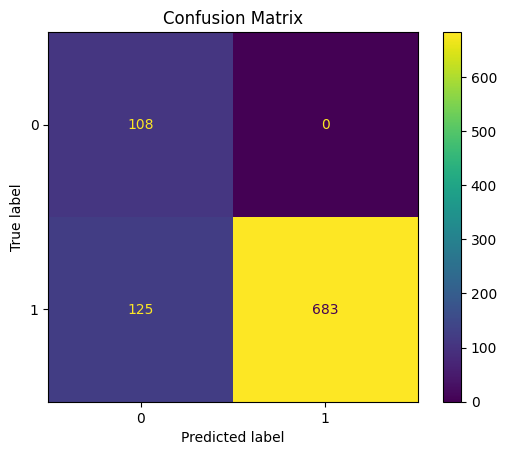

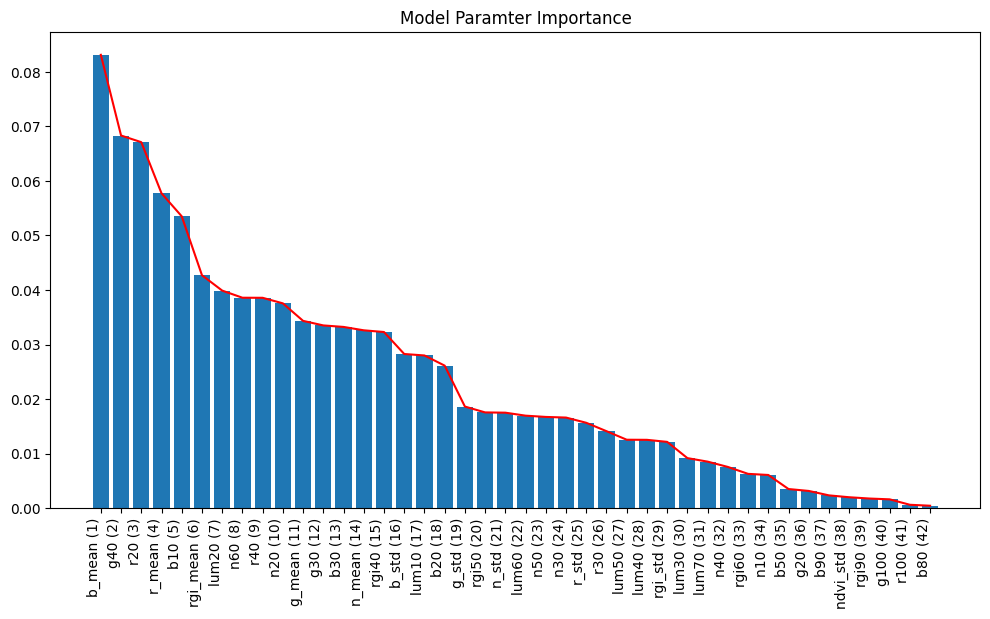

In [39]:

X = data2022[cols]
y = data2022.label



# report and plot first n features
# use 10 fold validation
score = cross_val_score(model, X, y, n_jobs=-1, cv=10, scoring='roc_auc')
pred = model.predict(X)
n_feat = range(n_cols)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print(f'model with {rf_n_estimators} estimators and max depth of {rf_max_depth}.')
print(f'ROC AUC: {score.mean().round(2)}')
print('\nFeature ranking:')
for f in n_feat:
    print('   %d.  %s (%f)' % (f + 1, cols[indices[f]], importances[indices[f]]))

cm = confusion_matrix(y, pred)
cm_display1 = ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')

fig, ax = plt.subplots(figsize=(12, 7))
fig.autofmt_xdate(rotation=45)
ax.bar(n_feat, importances[indices[n_feat]]);
ax.plot(n_feat, importances[indices[n_feat]], c='r');
ax.set_xticks(n_feat,rotation=90, labels=n_feat);
ax.set_xticklabels([f'{cols[indices[i]]} ({i+1})' for i in n_feat]);
ax.set_title('Model Paramter Importance');




In [ ]:

data2022['y_pred_2022'] = y_pred_2022
data2022 = data2022[['IDdalponte', 'y_pred_2022']]
data2022 = data2022.set_index('IDdalponte')



In [ ]:
data = pd.merge(pd.merge(data2022, data2020, left_index=True, right_index=True), data2018, left_index=True, right_index=True)
data

In [ ]:
# make sure that if a tree is alive, it was not dead in previous years.
lazurus = 0
for i, row in data.iterrows():
    if row.y_pred_2022 == 1:
        if (row.y_pred_2020 == 0) | (row.y_pred_2018 == 0):
            lazurus = lazurus + 1
            row['y_pred_2020'] = 1
            row['y_pred_2018'] = 1
print(f'there were {lazurus} resurections out of {len(data)} polygons.')

In [ ]:
crowns.index = crowns.index.astype(int)

crowns = crowns.join(
    data[['y_pred_2022', 'y_pred_2020', 'y_pred_2018']],
    how='left'
    )

In [ ]:
# write the crowns
out_path = '/home/michael/data/TreeMortality/crowns/USGS_LPC_CA_CarrHirzDeltaFires_2019_B19_10TDL0462745097_pred.gpkg'
crowns.to_file(out_path, index=False)